In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
# Loading Data
ml1m_dir = "./data/raw/ratings.dat"
ml1m_rating = pd.read_csv(ml1m_dir, sep='::', header=None, names=['uid', 'mid', 'rating', 'timestamp'],  engine='python')


In [2]:
# Reindex and cleaning data to accurate format
user_id = ml1m_rating[['uid']].drop_duplicates().reindex()
user_id['userId'] = np.arange(len(user_id))
ml1m_rating = pd.merge(ml1m_rating, user_id, on=['uid'], how='left')
item_id = ml1m_rating[['mid']].drop_duplicates()
item_id['itemId'] = np.arange(len(item_id))
ml1m_rating = pd.merge(ml1m_rating, item_id, on=['mid'], how='left')
ml1m_rating = ml1m_rating[['userId', 'itemId', 'rating', 'timestamp']]


In [3]:
# Convert the timestamp column to a datetime object
ml1m_rating['date'] = pd.to_datetime(ml1m_rating['timestamp'], unit='s')  # Assuming Unix timestamp in seconds
ml1m_rating['date'] = ml1m_rating['date'].dt.strftime('%Y-%m-%d')
df=ml1m_rating


In [4]:
#df - Dataframe of our movielens dataset for processing
df

,userId,itemId,rating,timestamp,date
0,0,0,5,978300760,2000-12-31
1,0,1,3,978302109,2000-12-31
2,0,2,3,978301968,2000-12-31
3,0,3,4,978300275,2000-12-31
4,0,4,5,978824291,2001-01-06
...,...,...,...,...,...
1000204,6039,772,1,956716541,2000-04-26
1000205,6039,1106,5,956704887,2000-04-25
1000206,6039,365,5,956704746,2000-04-25
1000207,6039,152,4,956715648,2000-04-26


In [5]:
#Function to find the number of days between 2 dates
def days_difference(date1, date2):

    # Convert string dates to datetime objects
    date1 = datetime.strptime(date1, '%Y-%m-%d')
    date2 = datetime.strptime(date2, '%Y-%m-%d')

    # Calculate the difference in days
    difference = -(date2 - date1).days

    return difference

# Function to convert number of days to years
def days_to_year(days):
  return days/365

## A basic logistic function - Used later to help derive time-decayed ratings
def logistic(tu_c):
    exponent = -tu_c
    denominator = 1 + math.exp(exponent)
    result = 1 / denominator
    return result

In [6]:
# Defining a couple of required dates to help derive time-weighted ratings
# Purpose explained in future paragraphs below
max_review_date = df['date'].max()
min_review_date = df['date'].min()

date_max = datetime.strptime(max_review_date, "%Y-%m-%d")
date_min = datetime.strptime(min_review_date, "%Y-%m-%d")

midpoint_date = (date_min + (date_max - date_min) / 2).strftime("%Y-%m-%d")
diff_max_midpoint = days_to_year(days_difference(max_review_date,midpoint_date))
diff_min_midpoint = days_to_year(days_difference(min_review_date,midpoint_date))

In [7]:
#Finding the "maximum"/latest date among all Movielens reviews
max_review_date

# date_max - Converts max_review_date to datetime format

'2003-02-28'

In [8]:
#Finding the "minimum"/earliest date among all Movielens reviews
min_review_date

# date_min - Converts min_review_date to datetime format

'2000-04-25'

In [9]:
#Find the middle date between max_review_date and min_review_date
midpoint_date

'2001-09-26'

In [10]:
#Find the days difference between the maximum date and the midpoint date
diff_max_midpoint

1.4246575342465753

In [11]:
#Find the days difference between the minimum date and the midpoint date
diff_min_midpoint

-1.4219178082191781

In [12]:
#Function to help normalise the time(in years) of each rating from the midpoint_date
#to the range [-1,1]
#Used to transform the years from middle date into input into the logistic function
def normalised(year,max_range_to_set=1,min_range_to_set=-1):
  max = diff_max_midpoint
  min = diff_min_midpoint
  normalised_value = (  (max_range_to_set-min_range_to_set)*((year-min)/(max-min))  )  + min_range_to_set
  return normalised_value

In [13]:
# For each rating, find out the years this particular rating is rated from the midpoint_date
df['years_from_midpoint'] = df.apply(lambda row: days_to_year(days_difference(row['date'],midpoint_date)),axis=1)

# Normalised the years from midpoint date to a range [-1,1]
df["normalised_year_from_midpoint"] =  df.apply(lambda row: normalised(row['years_from_midpoint']),axis=1)

# Calculate the time weight of the ratings
df['time_weight'] = df.apply(lambda row: logistic(row['normalised_year_from_midpoint']),axis=1)

# Weigh the ratings by its time weight to derive the time-weighted ratings
df['time_weighted_rating'] = df['time_weight']*df['rating']


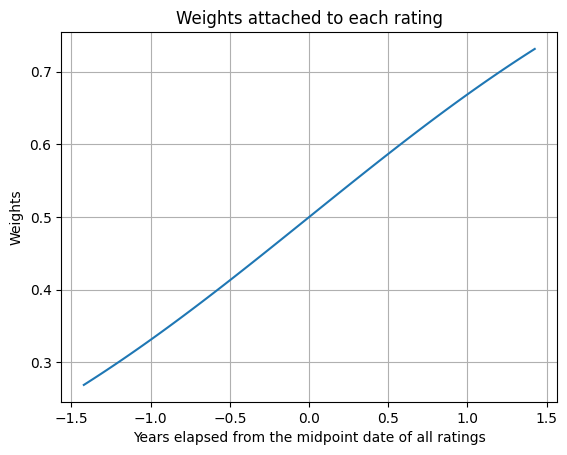

<Figure size 640x480 with 0 Axes>

In [14]:
tu_c_values = np.linspace(diff_min_midpoint, diff_max_midpoint, 100)

normalised_values = [normalised(tu_c) for tu_c in tu_c_values]
# Calculate logistic function for each tu_c value
logistic_values = [logistic(n_v) for n_v in normalised_values]

# Plot the logistic function that is normalised for better understanding
plt.plot(tu_c_values, logistic_values)
plt.title('Weights attached to each rating')
plt.xlabel('Years elapsed from the midpoint date of all ratings')
plt.ylabel('Weights')
plt.grid(True)
plt.show()

#Save figure and data
plt.savefig('time_weighted_rating_movielens1m.png')
df.to_csv('./data/processed/time_weighted_rating_movielens1m.csv', index=False)
